In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as warning
import os, re, string, pickle, warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)

In [2]:
nltk.download("stopwords")
nltk.download("punkt")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shahw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shahw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df = pd.read_csv("IMDB Dataset.csv")

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.info

<bound method DataFrame.info of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]>

In [6]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [7]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(418)

In [9]:
df.drop_duplicates( inplace=True)

In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
df.shape

(49582, 2)

In [12]:
plt.figure(figsize=(12,5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Text(0, 0.5, 'Count')

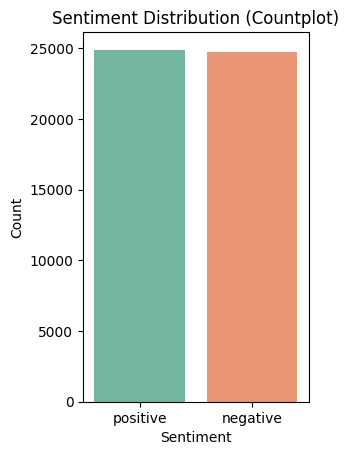

In [13]:
# Countplot
plt.subplot(1,2,1)
sns.countplot(x="sentiment", data=df, palette="Set2")
plt.title("Sentiment Distribution (Countplot)")
plt.xlabel("Sentiment")
plt.ylabel("Count")

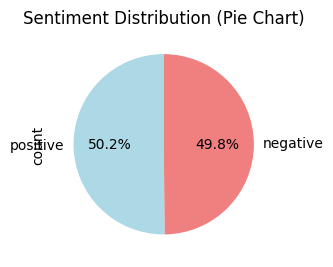

In [14]:
plt.subplot(1,2,2)
df["sentiment"].value_counts().plot.pie(autopct="%1.1f%%", colors=["lightblue","lightcoral"], startangle=90)
plt.title("Sentiment Distribution (Pie Chart)")

plt.show()

In [15]:
# --- Step 4: Data Preprocessing (Simplified) ---

# Encode sentiment: positive -> 1, negative -> 0
df["sentiment"] = df["sentiment"].map({"positive": 1, "negative": 0})

# Basic cleaning function
def clean_text(text):
    text = text.lower()                        # lowercase
    text = re.sub(r"[^a-zA-Z\s]", "", text)    # remove punctuation/numbers
    words = text.split()                       # tokenize
    words = [w for w in words if w not in stopwords.words("english")]  # remove stopwords
    return " ".join(words)

# Apply cleaning
df["clean_review"] = df["review"].apply(clean_text)

# Preview result
df.head()


,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,1,one reviewers mentioned watching oz episode yo...
1,A wonderful little production. <br /><br />The...,1,wonderful little production br br filming tech...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter matteis love time money visually stunni...


In [17]:
# --- Step 5: Split the Data ---

# Features (cleaned reviews) and target (sentiment)
X = df["clean_review"]
y = df["sentiment"]

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])


Training set size: 39665
Testing set size: 9917


In [18]:
# --- Step 6: Text Vectorization (TF-IDF) ---

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit on training data and transform both train & test sets
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("Training TF-IDF shape:", X_train_tfidf.shape)
print("Testing TF-IDF shape:", X_test_tfidf.shape)


Training TF-IDF shape: (39665, 5000)
Testing TF-IDF shape: (9917, 5000)


In [19]:
# --- Step 7: Model Training ---

# Initialize Multinomial Naive Bayes model
nb_model = MultinomialNB()

# Train the model on TF-IDF features
nb_model.fit(X_train_tfidf, y_train)

print("✅ Model training complete")


✅ Model training complete


Accuracy: 0.8518

Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.85      0.85      4940
    Positive       0.85      0.86      0.85      4977

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917



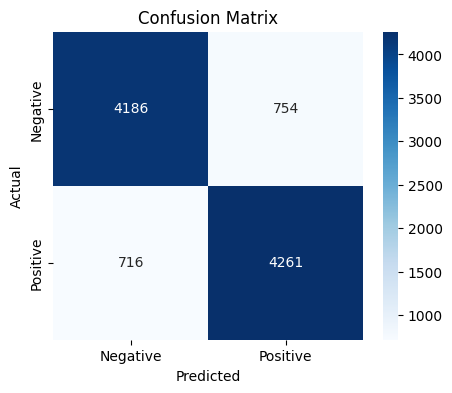

In [20]:
# --- Step 8: Model Evaluation ---

# Predictions on test set
y_pred = nb_model.predict(X_test_tfidf)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy, 4))

# Precision, Recall, F1
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [21]:
# --- Step 9: Identify Important Words ---

# Get feature names from TF-IDF
feature_names = tfidf.get_feature_names_out()

# Get log probabilities for each word
word_probs = nb_model.feature_log_prob_

# Top 20 words for Negative (class 0) and Positive (class 1)
top_neg = np.argsort(word_probs[0])[-20:]
top_pos = np.argsort(word_probs[1])[-20:]

print("🔴 Top Negative words:")
for i in top_neg:
    print(feature_names[i])

print("\n🟢 Top Positive words:")
for i in top_pos:
    print(feature_names[i])


🔴 Top Negative words:
get
much
plot
story
could
acting
see
movies
time
dont
really
would
good
even
bad
like
one
film
movie
br

🟢 Top Positive words:
much
first
films
people
would
best
also
love
time
really
well
see
story
like
good
great
one
film
movie
br


In [22]:
# --- Step 10: Save Model and Vectorizer ---

import pickle

# Save the trained model
with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(nb_model, f)

# Save the TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

print("✅ Model and Vectorizer saved successfully!")


✅ Model and Vectorizer saved successfully!


In [29]:
# Load model
with open("sentiment_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

# Load vectorizer
with open("tfidf_vectorizer.pkl", "rb") as f:
    loaded_tfidf = pickle.load(f)

# Example prediction
sample = ["This movie was sooo bad and not intresting "]
sample_tfidf = loaded_tfidf.transform(sample)
print("Prediction:", loaded_model.predict(sample_tfidf)[0])  # 1 = positive, 0 = negative


Prediction: 0
